In [1]:
#basic package
import json
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import shutil
import time
import datetime as dt
import itertools
import time
import re
from collections import Counter
from collections import defaultdict
import operator
import math
import pickle

#DTW
import dtaidistance
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
from dtaidistance import clustering

#plot
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#change r to 0 from 0.2
sys.path.append('C:\\Users\\camil\\Desktop\\animals_code\\entropy')
from entropy.entropy import sample_entropy
#from entropy.entropy import sample_entropy #https://github.com/raphaelvallat/entropy

In [3]:
from UTILS import time_series_henColumn_tsRow, ZoneVariable, HenVariable, DistributionEntropy, \
heatmap_duration_perzone_perhen, TimeSeriesPlot, entropy_compare_session
import config_mobility as config

c:\users\camil\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
c:\users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


we restrict the time series to one value per 60 seconds 
we compute the complexity variables each 30 minutes 
each variables includes the values of at least the last 120.00 minutes (i.e. are using 120.00 values)


In [4]:
path_extracted_data = config.path_extracted_data
id_run = config.id_run
nbr_sec = config.nbr_sec
path_extracted_visual = os.path.join(path_extracted_data, 'visual', 'ind_consistency', 'DTW')
#create a director if not existing
if not os.path.exists(path_extracted_visual):
    os.makedirs(path_extracted_visual)

In [5]:
#day level
ts_name = 'time_serie_day'

## DTW per hen

#aggreagate ts per hen 
START_TIME = time.clock()
window=120; value_delta=30
dico_zone_order = config.dico_zone_order
li_path = glob.glob(os.path.join(path_extracted_data, id_run+'_TimeSeries_*.csv'))
li_path = [i for i in li_path if '_hen_' not in i]
dico_zone_order_fl = {k:float(v) for k,v in dico_zone_order.items()}
li_df = []
for path_ in tqdm.tqdm(li_path):
    
    #download time series associated to this session
    name_ = path_.split('_')[-1].split('.')[0]
    print('-------------------------------------------------------------------------', name_)
    df_ts = pd.read_csv(path_, sep=';', parse_dates=['Timestamp', 'day']) 
    #keep one value per value_delta value
    df_ts['nbr'] = range(df_ts.shape[0])
    df_ts = df_ts.fillna(' ')
    df_ts['to_keep'] = df_ts['nbr'].map(lambda x: x%value_delta==0)
    df_ts = df_ts[df_ts['to_keep']]
    #keep only form 2h to 17h
    df_ts = df_ts[df_ts['hour'].isin([2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])]
        
    li_hen = [i for i in df_ts.columns if i.startswith('hen_')]
    df_ts_dtw = df_ts.groupby(['day'])[li_hen].agg(lambda x: [dico_zone_order_fl[i] for i in x if i!=' ']).stack().reset_index()
    df_ts_dtw['name'] = df_ts_dtw.apply(lambda x: str(x['day']).split(' ')[0]+'_'+x['level_1'], axis=1)
    df_ts_dtw.rename(columns={0:'ts', 'level_1':'HenID'}, inplace=True)        
    li_df.append(df_ts_dtw)
    
df = pd.concat(li_df)
df['nbr_values'] = df['ts'].map(lambda x: len(x))
display(df['nbr_values'].value_counts())
df = df[df['nbr_values']==1800]
print(df.shape)
df.head(3)

In [6]:
#avoid recomputation assuming its same value delta!!
#li_path_dicoS = glob.glob(os.path.join(path_,id_run+'dico_S_*.pkl'))
#if len(li_path_dicoS)>0:
#    for path_ in li_path_dicoS:
#        dico_S = pickle.load(open(path_, 'rb'))

#compute DTW
dico_h = {}
df.sort_values(['HenID','day'], inplace=True)
df_ = df.groupby(['HenID'])[['day','name','ts']].agg(lambda x: list(x)).reset_index()
for i in tqdm.tqdm(range(df_.shape[0])):
    x = df_.iloc[i]
    li_name = x['name']
    henID = x['HenID']
    ts = x['ts']
    print(henID)
    for j in range(len(li_name)-1):
        h1 = li_name[j] ; h2 = li_name[j+1]
        li_h1 = ts[j] ; li_h2 = ts[j+1]
        li_h1 = np.array(li_h1, dtype=np.double) ; li_h2 = np.array(li_h2, dtype=np.double)
        d, paths = dtw.warping_paths(li_h1, li_h2, window=window, psi=2)
        if henID not in dico_h:
            dico_h[henID] = {}
        dico_h[henID][(h1,h2)] = d
pickle.dump(dico_h, open(os.path.join(path_extracted_data,id_run+'dico_h_DTW.pkl'), 'wb'))

2016-06-02 00:00:00


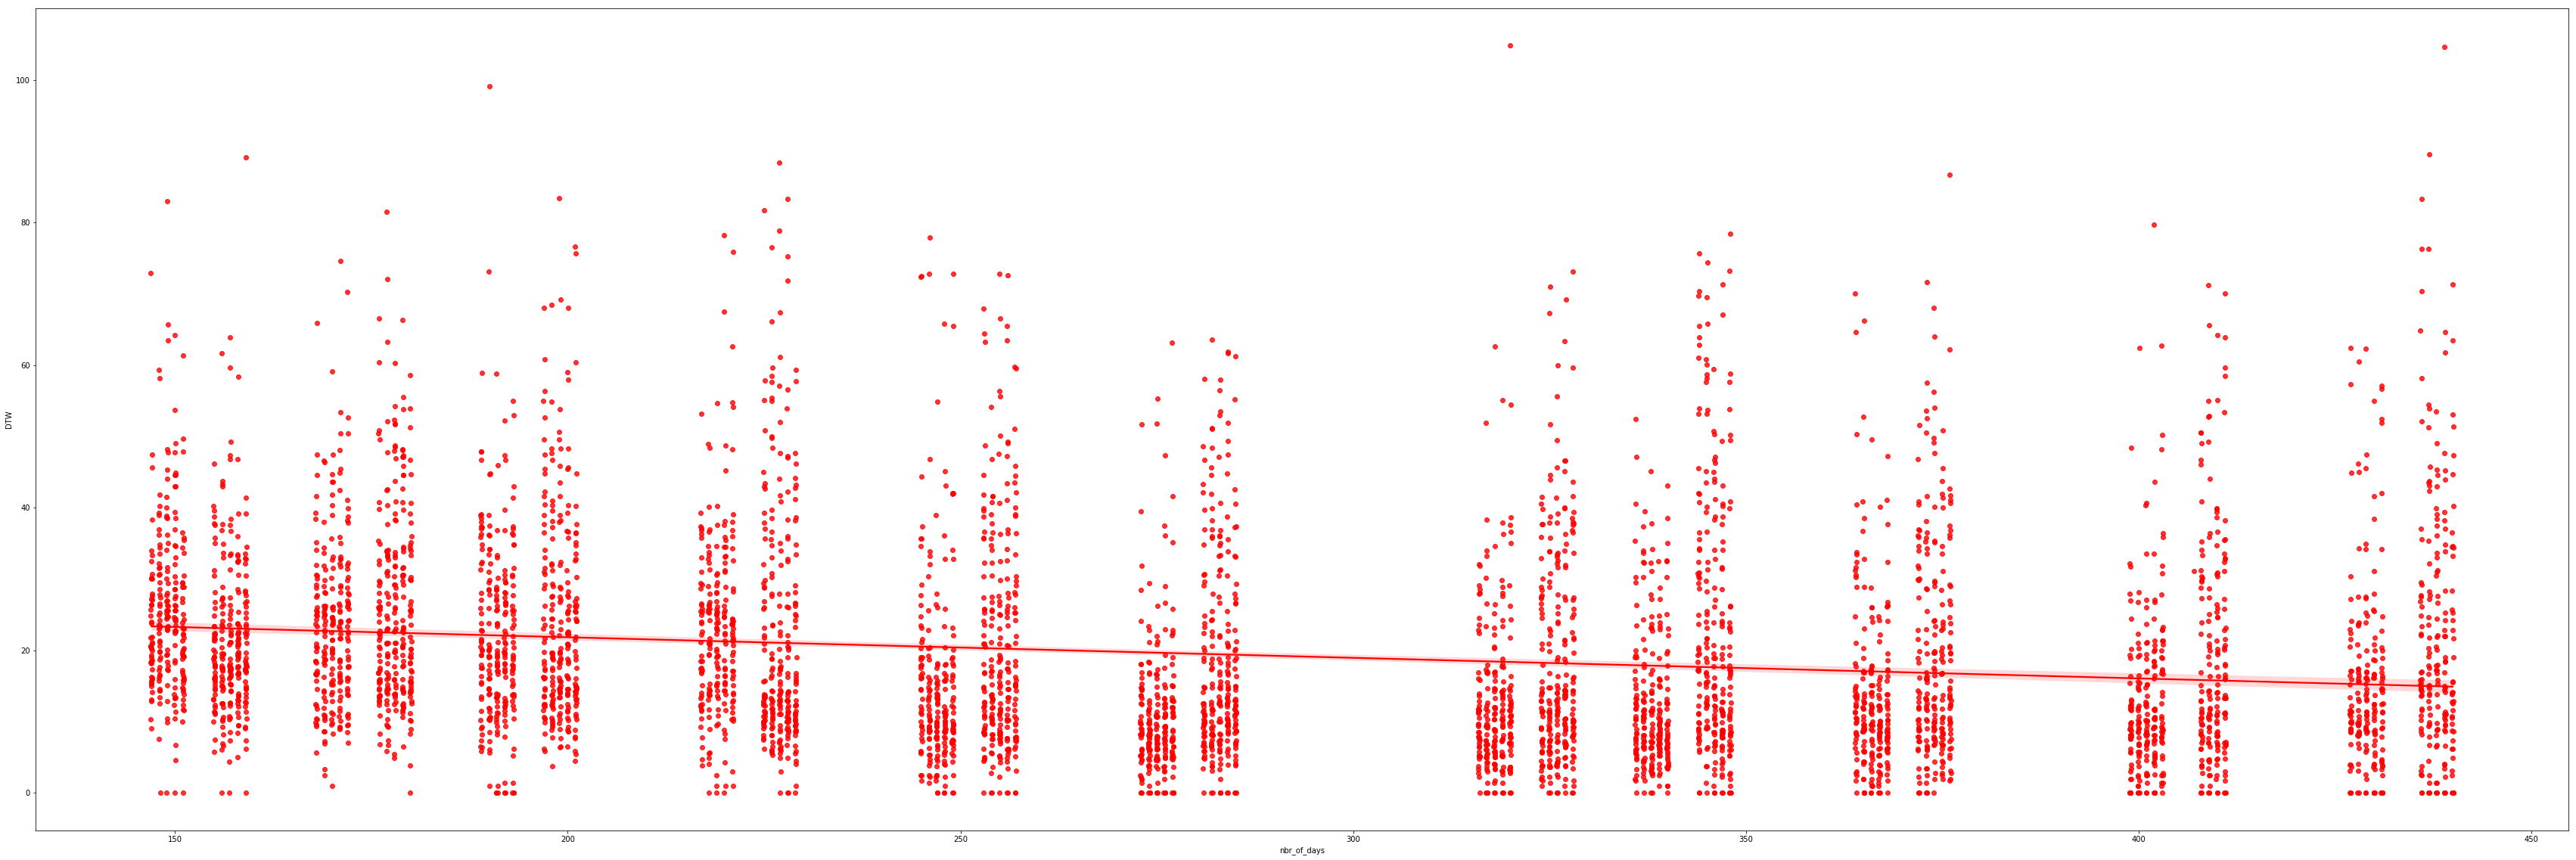

In [7]:
dico_h = pickle.load(open(os.path.join(path_extracted_data,id_run+'dico_h_DTW.pkl'), 'rb'))

#remove non consecutive days
dico_h = {hen:{tupleday:v2 for tupleday,v2 in v.items() if (dt.datetime.strptime(tupleday[1].split('_')[0], '%Y-%m-%d') - dt.datetime.strptime(tupleday[0].split('_')[0], '%Y-%m-%d')) == dt.timedelta(1)
} for hen,v in dico_h.items()}

#plot
li_name = []
li_line = []
li_x = []
li_y = []
for henID, dico_h1h2_d  in dico_h.items():
    y = list(dico_h1h2_d.values())
    x = [dt.datetime(int(d1.split('_')[0][0:4]),int(d1.split('_')[0][5:7]),
                     int(d1.split('_')[0][8:])) for d1,d2 in dico_h1h2_d.keys()]
    #li_line.append([list(dico_h1h2_d.values()), [dt.datetime(int(d1.split('_')[0][0:4]),int(d1.split('_')[0][5:7]),
    #                                                   int(d1.split('_')[0][8:])) for d1,d2 in dico_h1h2_d.keys()]])
    if len(x)>40:
        li_x.extend(x)
        li_y.extend(y)
        li_name.extend([henID for i in range(len(y))])
        #plt.plot(x,y, 'ro')
df_plot = pd.DataFrame({'level':li_x, 'DTW':li_y, 'HenID':li_name})
born_date = dt.datetime(2016,10,27)-dt.timedelta(days=21*7) #2016-10-27: 21 weeks 
print(born_date)
df_plot['nbr_of_days'] = df_plot['level'].map(lambda x: (x-born_date).days)
fig = plt.figure(figsize=(60, 20))
ax = sns.regplot(x="nbr_of_days", y="DTW", data=df_plot, x_jitter=.1, color='red')
plt.savefig(os.path.join(path_extracted_visual, 'DTW_overtime.png'),dpi=300,format='png',bbox_inches='tight')

In [8]:
# add info
df_movement = pd.read_csv(os.path.join(path_extracted_data, 'df_movement.csv'), sep=';', parse_dates=['day'])
df_movement.rename(columns={'day':'level'}, inplace=True)
df_movement = df_movement.filter(['HenID','SessionID','level','severity','hybrid']).drop_duplicates(subset=None, keep='first')
print(df_movement.shape)
display(df_movement.head(3))


li_path = glob.glob(os.path.join(path_extracted_data, id_run+'_'+ts_name+'_*_variables.csv'))
li_df = []
for path_ in tqdm.tqdm(li_path):
    #open the sessions-variable csv and select correct hen
    df_sess = pd.read_csv(path_, sep=';',
                           parse_dates=['level','FirstTimestamp_zone_1','FirstTimestamp_zone_2', 'FirstTimestamp_zone_3', 
                                        'FirstTimestamp_zone_4', 'FirstTimestamp_zone_5'])
    li_df.append(df_sess)
df_henLevel_summary = pd.concat(li_df)
print(df_henLevel_summary.shape)
display(df_henLevel_summary.head(3))

df_all = pd.merge(df_henLevel_summary, df_movement, on=['HenID','level'], how='left')
print(df_all.shape)
df_all.head(3)

print(df_plot.shape)
df_plot = pd.merge(df_plot, df_all, on=['HenID', 'level'], how='left')
print(df_plot.shape)
df_plot.head(2)

df_sev = df_plot.groupby(['HenID', 'SessionID'])['severity'].agg(lambda x: list(x)[0] if len(set(x))==1 else -2).reset_index()
print(df_sev[df_sev['severity']==-2].shape)
df_sev = df_sev.groupby(['HenID'])['severity'].max().reset_index()
df_sev.rename(columns={'severity':'max_severity'}, inplace=True)
df_plot = pd.merge(df_plot, df_sev, on=['HenID'], how='left')
df_plot['severity'].fillna(-1, inplace=True)
df_plot['Total_number_transition_cat'] = df_plot['Total_number_transition'].map(lambda x: x-x%30)
#df_plot['reasonable_KF'] = df_plot['max_severity'].map(lambda x: x<6)
df_plot['max_severity'] = df_plot['max_severity'].map(lambda x: round(x))
df_plot['round_severity'] = df_plot['severity'].map(lambda x: round(x))
print(df_plot.shape)
df_plot.head(2)

(6924, 5)


,HenID,SessionID,level,severity,hybrid
0,hen_1,1A,2016-10-27,0.0,LSL
92,hen_1,1A,2016-10-28,0.0,LSL
201,hen_1,1A,2016-10-29,0.0,LSL


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:04<00:00,  3.07s/it]


(7061, 55)


,FirstTimestamp_zone_1,FirstTimestamp_zone_2,FirstTimestamp_zone_3,FirstTimestamp_zone_4,FirstTimestamp_zone_5,HenID,Max_duration_zone_4,Max_duration_zones,SampEnt_order2,Total_number_transition,...,percentile_15,percentile_5,percentile_85,percentile_95,t_DU_missingZone_mvtPerc,up_missingZone_mvtNbr,up_missingZone_mvtPerc,variance_duration,verification_daily_total_duration,zone_list
0,NaT,NaT,2017-07-06 09:09:28,2017-07-06 02:18:44,2017-07-06 02:00:00,hen_1,4000.0,zone_5,0.000709,27,...,4.146667,0.594167,75.785833,116.513333,"(3.7037037037037033, 0.0, 28)",0.0,0.000000,1558.547945,54000.0,"('zone_5', 'zone_5', 'zone_5', 'zone_5', 'zone..."
1,NaT,2017-07-07 10:56:30,2017-07-07 10:46:28,2017-07-07 04:34:12,2017-07-07 02:00:00,hen_1,4267.0,zone_5,0.000846,40,...,0.416667,0.050000,61.266667,97.116667,"(0.0, 0.0, 41)",0.0,0.000000,1247.725845,54000.0,"('zone_5', 'zone_5', 'zone_5', 'zone_5', 'zone..."
2,NaT,NaT,2017-07-08 05:28:13,2017-07-08 05:19:38,2017-07-08 02:00:00,hen_1,3896.0,zone_5,0.000749,33,...,2.797500,1.106667,65.097500,73.026667,"(0.0, 3.0303030303030303, 34)",1.0,3.030303,1462.353481,54000.0,"('zone_5', 'zone_5', 'zone_5', 'zone_5', 'zone..."


(7061, 58)
(5367, 4)
(5367, 60)
(14, 3)
(5367, 63)


,DTW,HenID,level,nbr_of_days,FirstTimestamp_zone_1,FirstTimestamp_zone_2,FirstTimestamp_zone_3,FirstTimestamp_zone_4,FirstTimestamp_zone_5,Max_duration_zone_4,...,up_missingZone_mvtPerc,variance_duration,verification_daily_total_duration,zone_list,SessionID,severity,hybrid,max_severity,Total_number_transition_cat,round_severity
0,15.968719,hen_1,2016-10-27,147,2016-10-27 11:53:58,2016-10-27 04:39:25,2016-10-27 04:45:51,2016-10-27 02:00:00,2016-10-27 04:29:17,8957.0,...,0.000000,356.312192,54000.0,"('zone_4', 'zone_4', 'zone_4', 'zone_4', 'zone...",1A,0.0,LSL,2,90,0
1,18.734994,hen_1,2016-10-28,148,2016-10-28 12:08:35,2016-10-28 04:31:25,2016-10-28 04:33:59,2016-10-28 02:00:00,2016-10-28 04:27:40,8860.0,...,1.851852,269.367341,54000.0,"('zone_4', 'zone_4', 'zone_4', 'zone_4', 'zone...",1A,0.0,LSL,2,90,0


c:\users\camil\anaconda3\lib\site-packages\seaborn\regression.py:574: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


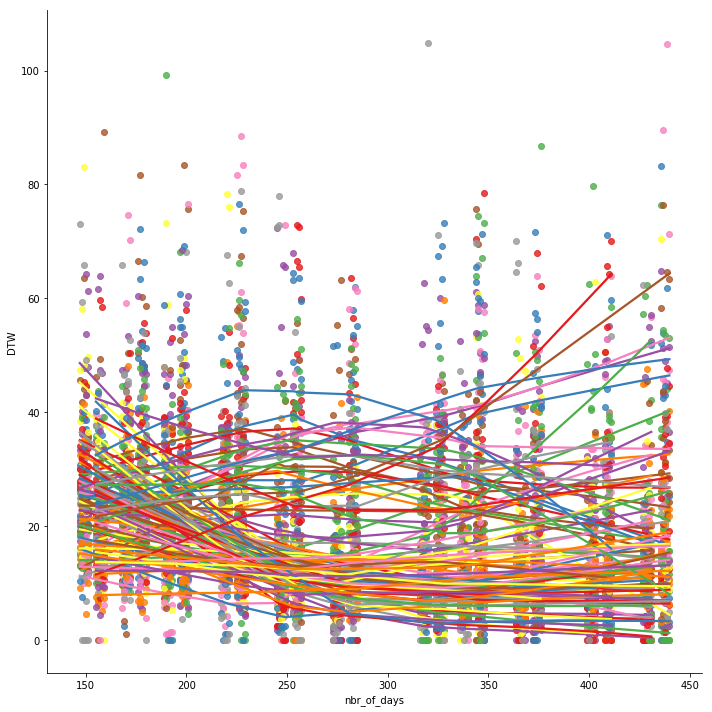

In [9]:
g = sns.lmplot(x="nbr_of_days", y="DTW", hue="HenID", data=df_plot, size=10, palette="Set1", legend=False, lowess=True); #, markers=["o", "x"];
#g = sns.lmplot(x="nbr_of_days", y="DTW", hue="Total_number_transition_cat", data=df_plot, size=7); #, markers=["o", "x"];
plt.savefig(os.path.join(path_extracted_visual, 'DTW_overtime_perhen.png'),dpi=300,format='png',bbox_inches='tight')

c:\users\camil\anaconda3\lib\site-packages\seaborn\regression.py:574: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


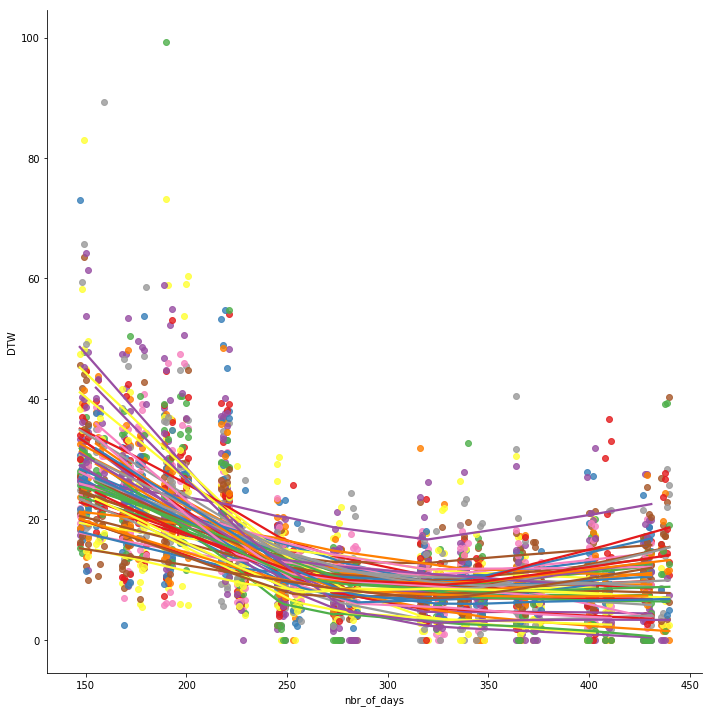

In [10]:
df_plot_LSL = df_plot[df_plot['hybrid']=='LSL']
g = sns.lmplot(x="nbr_of_days", y="DTW", hue="HenID", data=df_plot_LSL, size=10, palette="Set1", legend=False, lowess=True); #, markers=["o", "x"];
plt.savefig(os.path.join(path_extracted_visual, 'DTW_overtime_perhen'+'LSL'+'.png'),dpi=300,format='png',bbox_inches='tight')

c:\users\camil\anaconda3\lib\site-packages\seaborn\regression.py:574: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


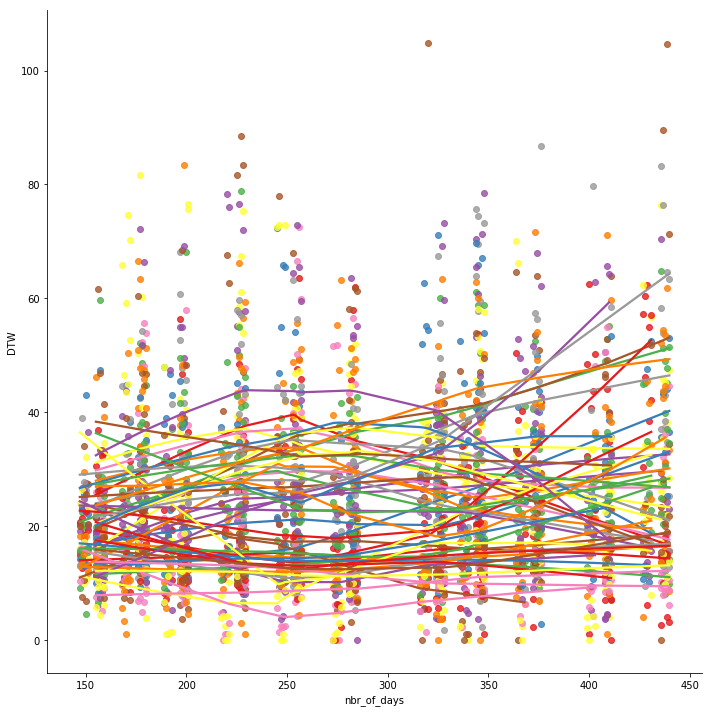

In [15]:
df_plot_LB = df_plot[df_plot['hybrid']=='LB']
g = sns.lmplot(x="nbr_of_days", y="DTW", hue="HenID", data=df_plot_LB, size=10, palette="Set1", legend=False, lowess=True); #, markers=["o", "x"];
plt.savefig(os.path.join(path_extracted_visual, 'DTW_overtime_perhen'+'LB'+'.png'),dpi=300,format='png',bbox_inches='tight')

c:\users\camil\anaconda3\lib\site-packages\seaborn\regression.py:574: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


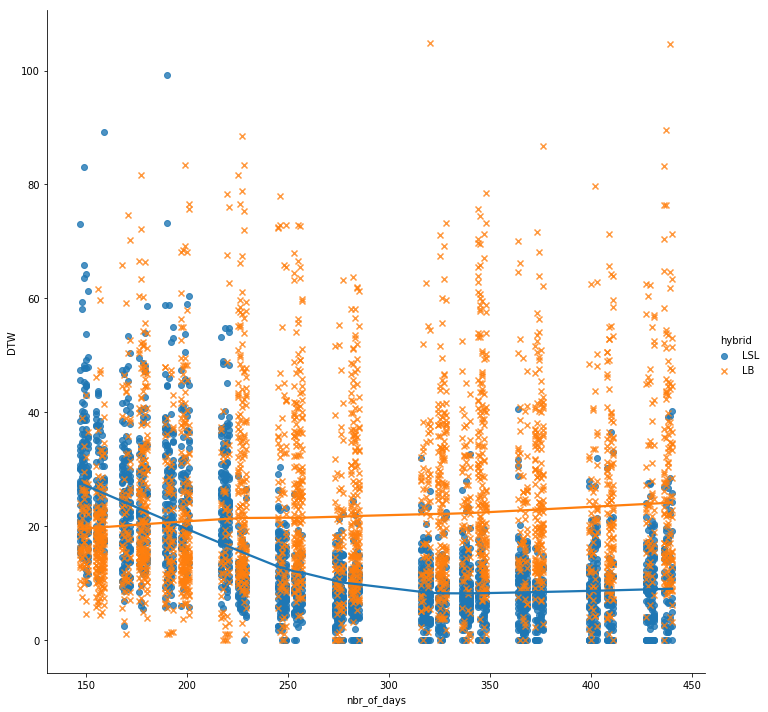

In [10]:
g = sns.lmplot(x="nbr_of_days", y="DTW", hue="hybrid", data=df_plot, size=10, markers=["o", "x"], lowess=True);
plt.savefig(os.path.join(path_extracted_visual, 'DTW_overtime_perhengroup.png'),dpi=300,format='png',bbox_inches='tight')

c:\users\camil\anaconda3\lib\site-packages\seaborn\regression.py:574: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


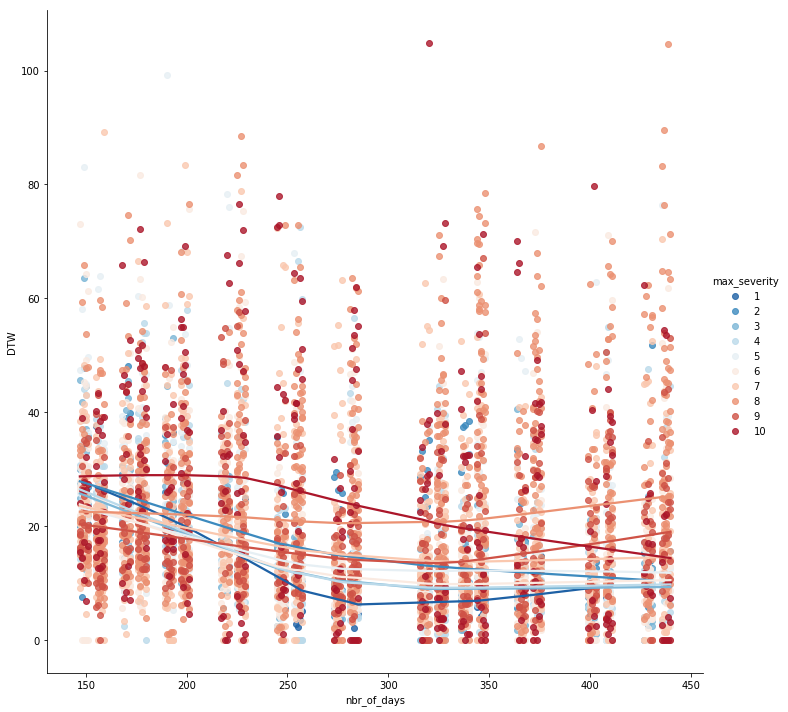

In [12]:
g = sns.lmplot(x="nbr_of_days", y="DTW", hue="max_severity", data=df_plot, size=10, lowess=True,
               palette=sns.color_palette("RdBu_r", n_colors=len(df_plot['max_severity'].unique()))); #, markers=["o", "x"];
#--> when you are not in pain your routine get stable over time. In contrary, when you have a high keel born fracture they
#dont seemed able to do their normal routine
plt.savefig(os.path.join(path_extracted_visual, 'DTW_overtime_permaxseverity.png'),dpi=300,format='png',bbox_inches='tight')

c:\users\camil\anaconda3\lib\site-packages\seaborn\regression.py:574: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


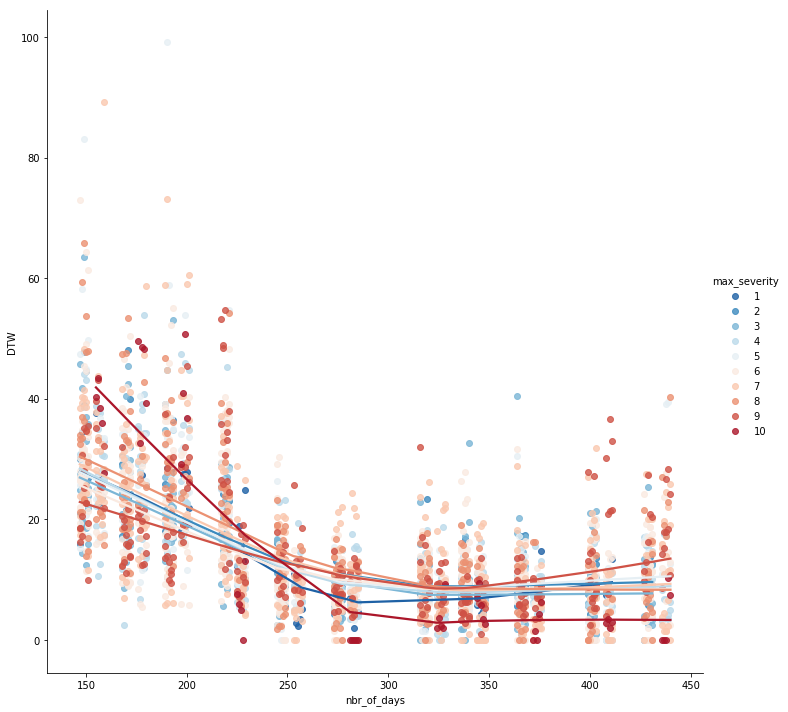

In [13]:
df_plot_LSL = df_plot[df_plot['hybrid']=='LSL']
g = sns.lmplot(x="nbr_of_days", y="DTW", hue="max_severity", data=df_plot_LSL, size=10, lowess=True,
               palette=sns.color_palette("RdBu_r", n_colors=len(df_plot_LSL['max_severity'].unique()))); 
#--> when you are not in pain your routine get stable over time. In contrary, when you have a high keel born fracture they
#dont seemed able to do their normal routine
plt.savefig(os.path.join(path_extracted_visual, 'DTW_overtime_permaxseverity_LSL.png'),dpi=300,format='png',bbox_inches='tight')

c:\users\camil\anaconda3\lib\site-packages\seaborn\regression.py:574: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


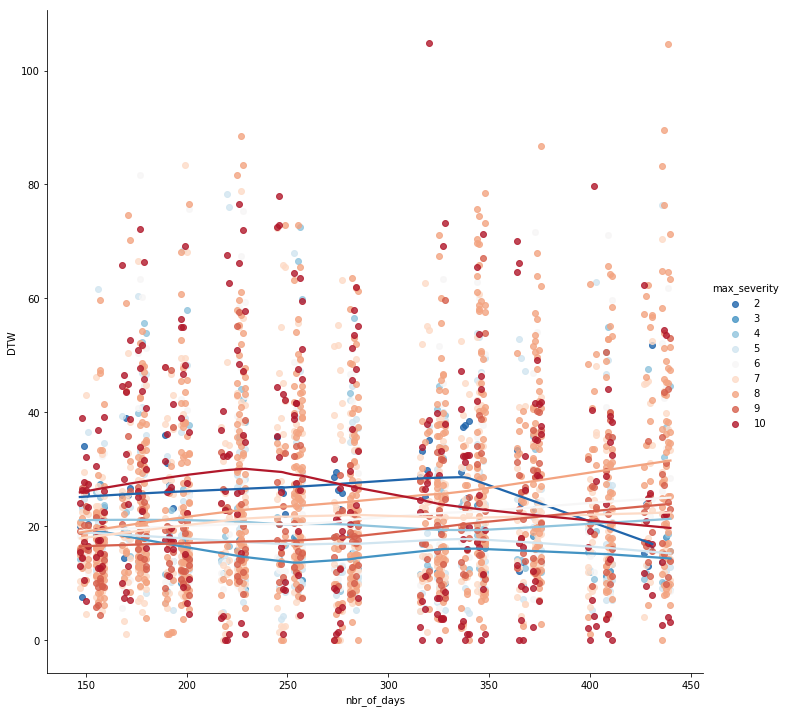

In [14]:
df_plot_LB = df_plot[df_plot['hybrid']=='LB']
g = sns.lmplot(x="nbr_of_days", y="DTW", hue="max_severity", data=df_plot_LB, size=10, lowess=True,
               palette=sns.color_palette("RdBu_r", n_colors=len(df_plot_LB['max_severity'].unique())));
plt.savefig(os.path.join(path_extracted_visual, 'DTW_overtime_permaxseverity_LB.png'),dpi=300,format='png',bbox_inches='tight')

c:\users\camil\anaconda3\lib\site-packages\seaborn\regression.py:574: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


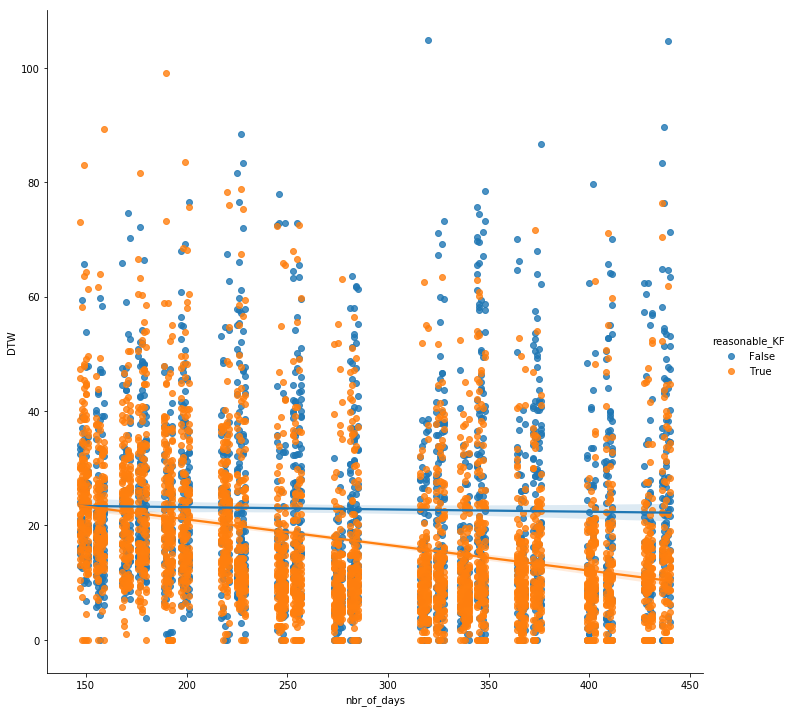

In [14]:
df_plot['round_severity'] = df_plot['severity'].map(lambda x: round(x))
df_plot['reasonable_KF'] = df_plot['max_severity'].map(lambda x: x<8)
g = sns.lmplot(x="nbr_of_days", y="DTW", hue="reasonable_KF", data=df_plot, size=10); #, markers=["o", "x"];
plt.savefig(os.path.join(path_extracted_visual, 'DTW_overtime_perreasonableKF.png'),dpi=300,format='png',bbox_inches='tight')

In [15]:
#TODO once egg production info
#g = sns.lmplot(x="nbr_of_days", y="DTW", hue="nbr_eggs", data=df_plot, markers=["o", "x"]);